In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import pandas as pd
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
import torch
import torch.nn as nn
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import random
from transformers import (
    ViTImageProcessor,
    ViTModel,
    ViTConfig,
    ViTPreTrainedModel,
    Trainer, 
    TrainingArguments,
    ViTForImageClassification,
    )
from sklearn.model_selection import train_test_split
import sys
from typing import List
from sklearn.metrics import classification_report
import gc
import argparse

import torch.nn.init as init
# parser = argparse.ArgumentParser(description="category parser")
# parser.add_argument("-ci","--category_idx", type=int, default=0,choices=[0,1,2,3,4],help="category index")
# args = parser.parse_args()


In [7]:

# model_name = 'google/vit-base-patch16-224'
# model_name="./vit/final"
model_name="./vit/checkpoint-471"
save_dir="./vit3/"
DEVICE="cuda:0"
def setAllSeeds(seed):
  os.environ['MY_GLOBAL_SEED'] = str(seed)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
# setAllSeeds(42)



In [8]:
df = pd.read_csv("train.csv")
categories=df["Category"].unique()
category=categories[0]

df = df[df["Category"]==category]
save_dir+=category
delCol = []
trackNum = []
for i in range(1,11):
    uniName = df["attr_"+str(i)].dropna().unique()
    if(len(uniName)==0):
        delCol.append("attr_"+str(i))
    else:
        trackNum.append(len(uniName))

df = df.drop(delCol,axis=1)

In [9]:
processor = ViTImageProcessor.from_pretrained(model_name)
model=ViTForImageClassification.from_pretrained(model_name,attn_implementation="eager")
model.to(DEVICE)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [ ]:
import matplotlib.pyplot as plt
import cv2


def get_attention_map(model, image_path, get_mask=False):
    image = Image.open(image_path)
    img = image
    inputs = processor(image, return_tensors="pt")
    outputs = model.forward(inputs['pixel_values'].to("cuda"))
    outputs = model(inputs['pixel_values'].to("cuda"), output_attentions=True).attentions
    # outputs = model.get_attention_map(inputs['pixel_values'].to("cuda"))
    # outputs = outputs.to("cpu")
    att_mat = torch.stack(outputs).squeeze(1)


    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1).to("cpu")

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1)).to("cpu")
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size()).to("cpu")
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    # v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    # mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    # if get_mask:
    #     result = cv2.resize(mask / mask.max(), img.size)
    # else:        
    #     mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
    #     result = (mask * img).astype("uint8")
    
    # return result
    return joint_attentions,grid_size

def plot_attention_map(image_path, get_mask=None):
    model.eval()
    original_img = Image.open(image_path)
    joint_att1, grid_size1 = get_attention_map(model, image_path, get_mask=get_mask)
    results=[]
    for i, v in enumerate(joint_att1):
        v = joint_att1[-1]
        mask = v[0, 1:].reshape(grid_size1, grid_size1).detach().numpy()
        if get_mask:
            result = cv2.resize(mask / mask.max(), original_img.size)
        else:        
            mask = cv2.resize(mask / mask.max(), original_img.size)[..., np.newaxis]
            result = (mask * original_img).astype("uint8")
        results.append(result)
    
    results=np.array(results)
    print(results.shape)
    results=results.mean(axis=0)
    print(results.shape)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map_%d Layer' % (i+1))
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(results)
    # fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    # ax1.set_title('Original')
    # ax2.set_title('Attention Map Last Layer')
    # _ = ax1.imshow(original_img)
    # _ = ax2.imshow(att_map)
    # return outputs

(12, 380, 512)
(380, 512)


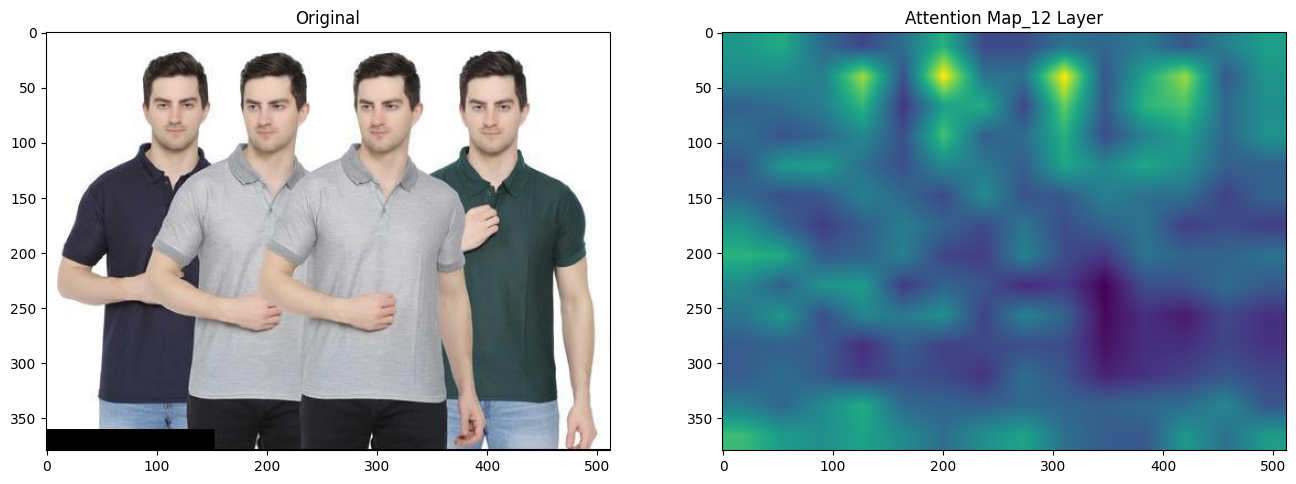

In [14]:
plot_attention_map('train_images/000002.jpg',get_mask=True)